In [2]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":2.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.viridis
savedir= '/home/dascoli/odeformer/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

gpu_index = get_most_free_gpu()

parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)        
args = parser.parse_args(args=[])
args.debug = False
env = FunctionEnvironment(args)


In [5]:
runs = []
logs = []
global_path = '/data/rcp/odeformer/experiments'

paths = [
    #'dropout'
    #'int_base'
    #'precision'
    #"curriculum"
    #"first"
    #"second"
    #"use_cross_attention"
    #"third"
    #"fixed_init_scale"
    #"two_hot"
    #"sympy"
    #"mlm"
    #"scale"
    #"poly_big"
    #"bounded"
    "poly_new"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        #try : 
        latest, latest_pmlb, latest_osc = -1, -1, -1
        run = {}
        args = pickle.load(open(dirname+'/params.pkl', 'rb'))
        run['args'] = args
        run['logs'] = []
        run['pmlb'] = []
        run['oscillators'] = []
        run['num_params'] = []
        logfile = dirname+'/train.log'
        f = open(logfile, "r")
        for line in f.readlines():
            if '__log__' in line or '__pmlb__' in line or '__oscillators__' in line: 
                log = eval(line[line.find('{'):].rstrip('\n'))
                epoch = log['epoch']
                if '__pmlb__' in line:
                    if epoch <= latest_pmlb: continue
                    latest_pmlb = epoch
                    run['pmlb'].append(log)
                elif '__oscillators__' in line:
                    if epoch <= latest_osc: continue
                    latest_osc = epoch
                    run['oscillators'].append(log)
                else:
                    if epoch <= latest: continue
                    latest = epoch
                    run['logs'].append(log)
        f.close()
        args.output_dir = Path(dirname)
        runs.append(run)
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/data/rcp/odeformer/experiments/poly_new/
4 runs found
/data/rcp/odeformer/experiments/poly_new/exp_n_enc_layers_4_n_dec_layers_12
/data/rcp/odeformer/experiments/poly_new/exp_n_enc_layers_4_n_dec_layers_16
/data/rcp/odeformer/experiments/poly_new/exp_n_enc_layers_8_n_dec_layers_12
/data/rcp/odeformer/experiments/poly_new/exp_n_enc_layers_8_n_dec_layers_16
0 fails


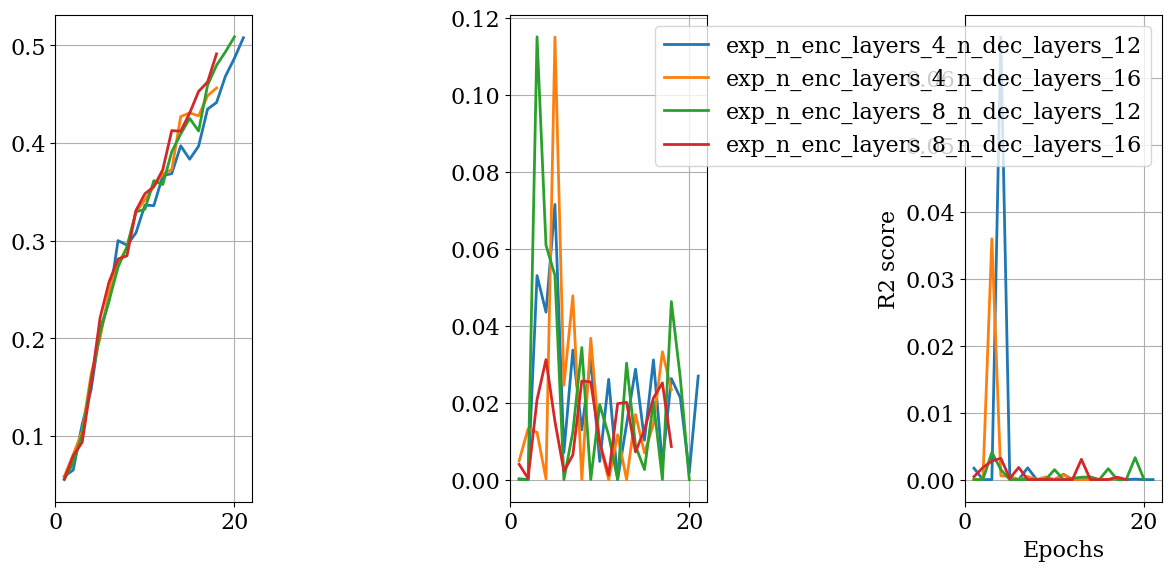

In [4]:
constraints = {
    #'optimizer': ['adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5'],
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
#selected_runs = runs

fig, axarr = plt.subplots(1,3,figsize=(12,6))

for i, mode in enumerate(['logs', 'pmlb', 'oscillators']): 
    for run in selected_runs[:]:
        args = run['args']
        times = np.array(range(len(run[mode])))#[:latest]
        r2    = [run[mode][t]['r2_zero']      for t in times]
        acc    = [run[mode][t]['accuracy_l1_1e-1']      for t in times]
        label = args.exp_id
        #label = 'dim {}'.format(lab)
        y = r2
        #print(loss,correct,perfect,additional)
        axarr[i].plot(times+1, y, label=label)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('R2 score')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

In [11]:
metric = 'accuracy_l1_1e-1'
infos = ['n_unary_ops', 'dimension', 'n_points']
metrics = [metric+'_info_'+info for info in infos]
legends = ['o', 'd', 'n']
labels = ['Number of unary operators', 'Dimension', 'Points']

selected_runs = [runs[0],runs[-1]]

for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            for t in range(len(run['logs'])):
                if key not in run['logs'][t]: run['logs'][t][key] = 100
            acc = [run['logs'][t][key] for t in range(len(run['logs']))][:150]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/(len(keys)-1)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        #ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('R2 score')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time.pdf')
    plt.show()      

ZeroDivisionError: division by zero

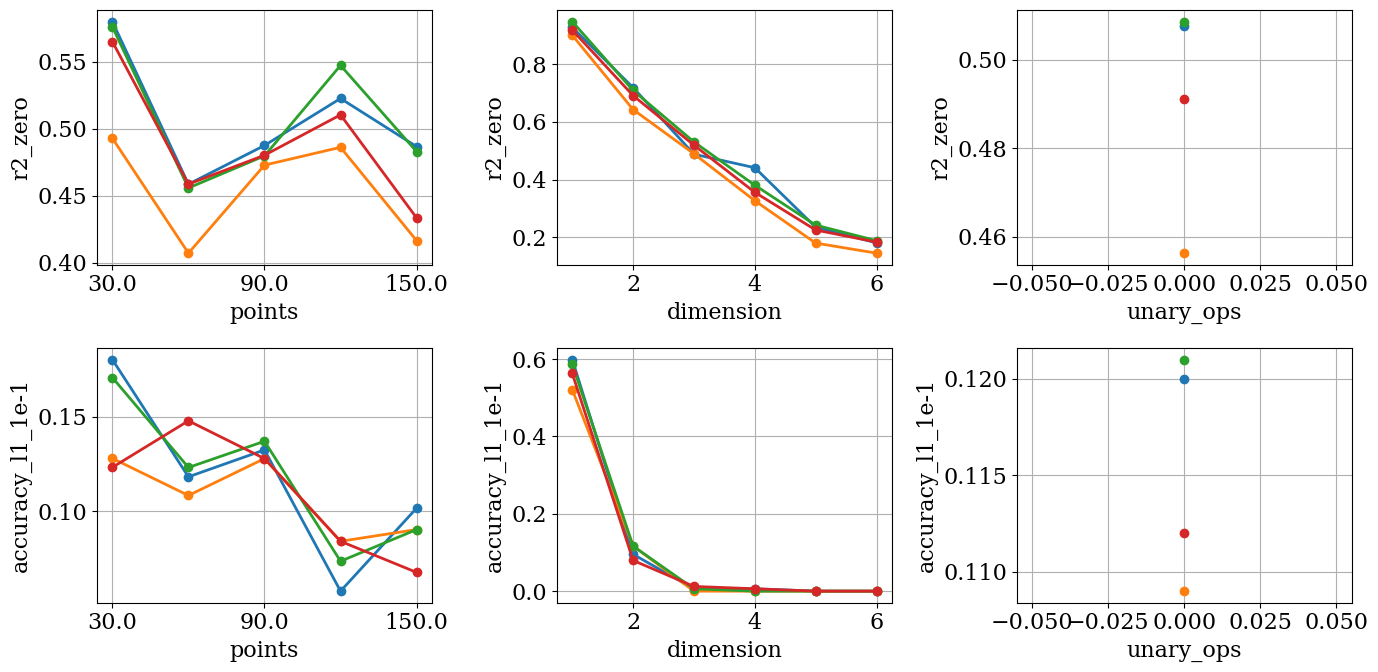

In [6]:
metrics = ['r2_zero', 'accuracy_l1_1e-1']
ablations = ['info_n_points', 'info_dimension', 'info_n_unary_ops']

# plot r2_zero vs info_n_points
fig, axarr = plt.subplots(len(metrics), len(ablations), figsize=(7*len(metrics),7))
for run in selected_runs:
    args = run['args']
    try:
        df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
    except:
        print("Skipped"); continue
    df = df.drop(columns=['predicted_trees', 'trees'])
    k = 5# bin info_n_points into k bins
    df['info_n_points'] = pd.cut(df['info_n_points'], bins=k, labels=np.arange(1,k+1)*df['info_n_points'].max()/k)
    for i, metric in enumerate(metrics):
        for j, ablation in enumerate(ablations):
            df.groupby(ablation)[metric].mean().plot(ax=axarr[i,j], marker='o', label=ablation)
            axarr[i,j].set_xlabel(ablation.lstrip('info_'))
            axarr[i,j].set_ylabel(metric)
            #axarr[i,j].set_xscale('log')
plt.tight_layout()
plt.show()


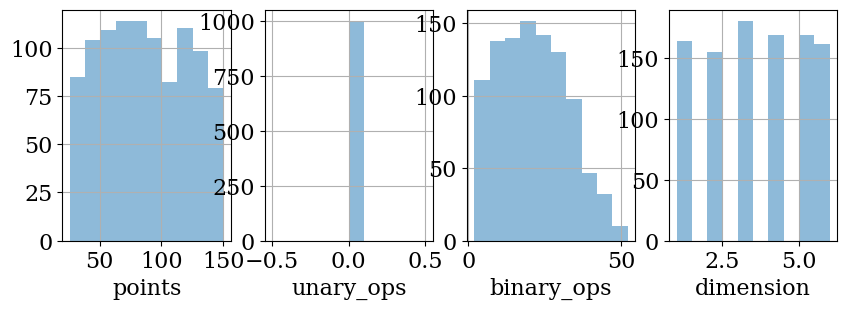

In [27]:
# plot r2_zero vs info_n_points
run = runs[0]
args = run['args']
df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
info_columns = [col for col in df.columns if col.startswith('info_')]
for run in selected_runs[:1]:
    fig, axarr = plt.subplots(1, len(info_columns), figsize=(10,3))
    args = run['args']
    df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
    # plot histograms for all info columns
    for i, col in enumerate(info_columns):
        df[col].hist(ax=axarr[i], alpha=0.5, label=col)
        axarr[i].set_xlabel(col.lstrip('info_'))
    


In [8]:
run = runs[1]
args = run['args']
df = pd.read_csv(args.output_dir/'evals_all/eval_in_domain.csv')
#df = pd.read_csv(args.output_dir/'evals_all/eval_pmlb.csv')
#df = df.query('info_n_masked_variables==1')
df = df.query('info_dimension==2')
#df = df.query('r2_zero>0.99')
for i, (_, sample) in enumerate(df.iterrows()):
    if i==20: break
    try:
        print(sample['r2_zero'])
        if hasattr(sample, 'trees'):
            print(''.join(['{:>80s}'.format(eq) for eq in sample['trees'].split('|')]))
        print(''.    join(['{:>80s}'.format(eq) for eq in sample['predicted_trees'].split('|')]))
        print()
    except: pass

0.0
                                                  -0.0843 * x_0 + -7.4911 * x_1                                                    18.8821 * x_0 + -0.0034 * x_1
                                                  -0.0948 * x_0 + -7.9780 * x_1                                                                    18.8600 * x_0

0.923932149860046
                                                   2.0365 * x_1 + -2.7404 * x_0                                                     0.8127 * x_1 + -0.6317 * x_0
                                                   2.3240 * x_1 + -3.0790 * x_0                                                     0.6420 * x_1 + -0.3889 * x_0

0.9286541717729512
                                                             1.8344 * x_0 * x_1  -2.4412 * x_1 + -1.7942 * (x_1)**2 + -1.2291 * x_0 * (x_1)**2 + -0.87228 * x_1 * (x_0)**2
                                                             1.6670 * x_0 * x_1                                         -3.5000 * x_1 + -1.270

# Load model

In [9]:
run = runs[0]
args = run['args']
extra_args = {
    'reload_checkpoint':run['args'].dump_path.replace('/sb_u0621_liac_scratch','/data/rcp'),
    'reload_data':run['args'].reload_data.replace('/sb_u0621_liac_scratch','/data/rcp'),
    'rescale':True,
              }
with stdout_redirected():
    dstr = load_run(run, extra_args=extra_args)

Reloading checkpoint from /data/rcp/odeformer/experiments/poly_new/exp_n_enc_layers_4_n_dec_layers_12/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 21 / iteration 63000 ...


In [46]:
dstr.rescale=True
dstr.average_trajectories=False

dstr.model.beam_type = 'sampling'
dstr.model.beam_size = 3
dstr.model.beam_temperature = .1

defaultdict(<class 'list'>, {0: [2.25 * 0.5488135039273248 * (1.087 * 1.8221125989866722 * x_0 + -0.3963 * 1.3982310797938675 * x_1 + -0.5768 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1) | 2.25 * 0.7151893663724195 * (-1.036 * 1.3982310797938675 * x_1 + 0.8049 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1), 2.25 * 0.5488135039273248 * (1.21 * 1.8221125989866722 * x_0 + -0.7975 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1) | 2.25 * 0.7151893663724195 * (-1.235 * 1.3982310797938675 * x_1 + 0.8399 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1), 2.25 * 0.5488135039273248 * (1.039 * 1.8221125989866722 * x_0 + -0.8031 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1) | 2.25 * 0.7151893663724195 * (-1.016 * 1.3982310797938675 * x_1 + 0.7981 * 1.8221125989866722 * x_0 * 1.3982310797938675 * x_1)]})


-1.8146*x_0*x_1 + 2.4458*x_0 - 0.6842*x_1

3.2999*x_0*x_1 - 2.331*x_1

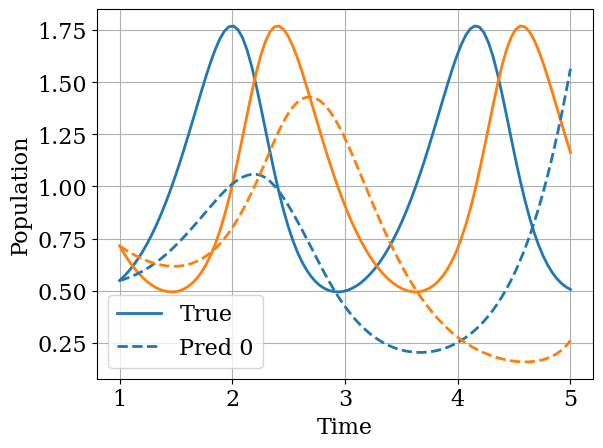

In [54]:
a = 3 # growth rate of rabbits
b = 3 # death rate of rabbits
c = 3 # death rate of foxes
d = 3 # growth rate of foxes
def lotka_volterra(X, t):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] - b*X[0]*X[1] ,
                     -c*X[1] + d*X[0]*X[1] ])
# def lotka_volterra(X, t):
#     """ Return the growth rate of fox and rabbit populations. """
#     return np.array([ - X[1] - 0*X[0]*X[1] ,
#                      X[0] - 0*X[0]*X[1] ])

# solve ODE
times, trajectories = [],[]
np.random.seed(0)
for _ in range(1):
    time = np.linspace(1,5,100)     # time
    y0 = np.random.uniform(0,1,size=(2,)) # initial conditions
    #y0 = [20,20]
    trajectory = integrate.odeint(lotka_volterra, y0, time)
    times.append(time)
    trajectories.append(trajectory)

plt.figure()
plt.plot(time, trajectories[0][:,0], color='C0', label='True')
plt.plot(time, trajectories[0][:,1], color='C1')


candidates = dstr.fit(times, trajectories, sort_metric='r2_zero')
print(candidates)
for i, tree in enumerate(candidates[0][:1]):
    sympy_trees = env.simplifier.tree_to_sympy_expr(tree)
    for sympy_tree in sympy_trees:
        display(sympy_tree)
    pred_trajectory = integrate_ode(trajectories[0][0], time, tree, "solve_ivp", debug=True)
    try:
        plt.plot(time, pred_trajectory[:,0], ls='--', label=f'Pred {i}')
        plt.plot(time, pred_trajectory[:,1], ls='--')
    except: 
        print(traceback.format_exc())
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

1.0 * 5.0 * (10.39 * 0.2 * x_0 + -15.68 * (0.2 * x_0)**2)
-3.136*x_0**2 + 10.39*x_0


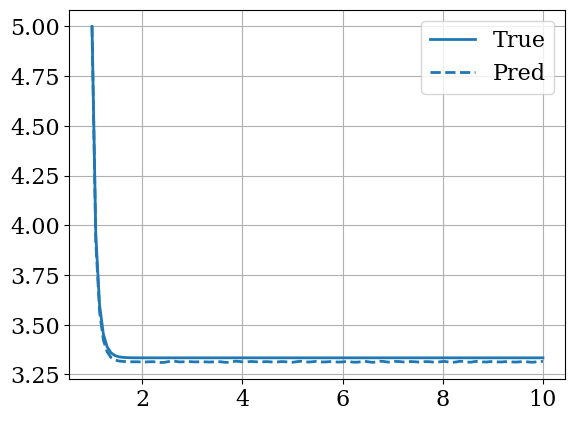

In [53]:
dstr.rescale=True
a = -3
b = 10
c = 0
def quadratic(X, t):
    return np.array([a*X[0]**2+b*X[0]+c])

# solve ODE
times = np.linspace(1, 10, 120)     # time
y0 = [5] # initials conditions
trajectory = integrate.odeint(quadratic, y0, times)
# plot results
plt.plot(times, trajectory[:,0], color='C0', label='True')

candidates = dstr.fit(times, trajectory)
tree = candidates[0][0]
for tree in candidates[0][:1]:
    print(tree)
    print(env.simplifier.readable_tree(tree))
    pred_trajectory = integrate_ode(y0,times, tree, "solve_ivp")
    plt.plot(sorted(times), pred_trajectory[:,0], color='C0', ls='--', label='Pred')
plt.legend()
plt.show()

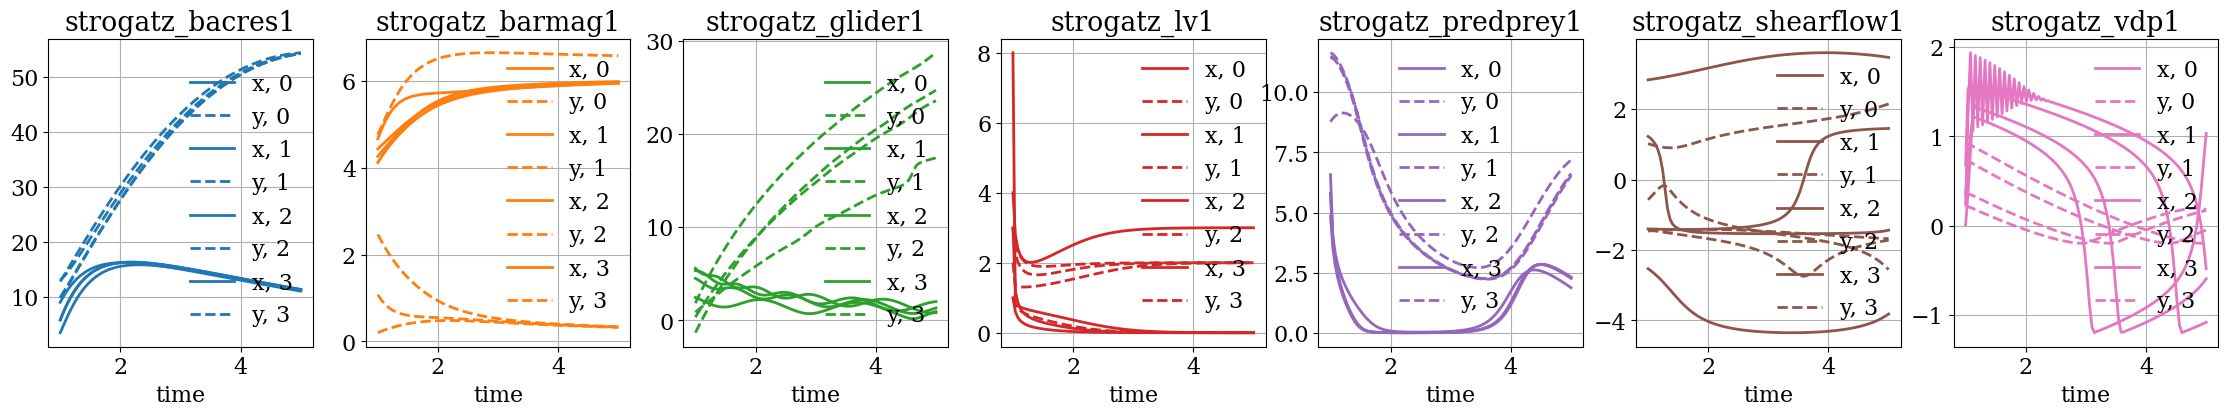

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pmlb import fetch_data, dataset_names
strogatz_names = [name for name in dataset_names if "strogatz" in name and "2" not in name]
n = len(strogatz_names)

times = np.linspace(1, 5, 100)

# Returns a pandas DataFrame
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
for i ,name in enumerate(strogatz_names):
    data = fetch_data(name)
    x = data['x'].values
    y = data['y'].values
    for j in range(4):
        start = j * len(times)
        stop = (j+1) * len(times)
        axarr[i].plot(times, x[start:stop], color=f"C{i}", ls='-', label=f"x, {j}")
        axarr[i].plot(times, y[start:stop], color=f"C{i}", ls='--', label=f"y, {j}")
    axarr[i].set_xlabel("time")
    axarr[i].legend(ncol=1, loc="best", frameon=False)
    axarr[i].set_title(name)
plt.show()

0 -0.0294*x_1*(0.1141*x_0 + 0.037*x_1) + 0.0969*x_1  ,  -0.0013*x_0*x_1 + 0.0708*x_0
1 -0.1129*x_0 + 0.0975*x_1  ,  -0.1248*x_0 + 0.1123*x_1
2 -0.0218*x_1*(-0.5968*x_0*(0.0099*x_0 - 0.2197*x_1) + 0.0337*x_0) - 0.0896*x_1  ,  0.0875*x_0
3 0.03*x_0*x_1*(-3.328*x_0 - 0.906*x_1)  ,  -1.6003*x_0**2
4 -1.1646*x_0*(-0.0203*x_0 + 0.0569*x_1) + 0.3564*x_0  ,  0.1375*x_0 - 0.0047*x_1**2
5 0.0052*x_0 - 0.0996*x_1*(0.0424*x_0 - 0.5792*x_1) + 0.0951*x_1  ,  -0.0314*x_0*x_1 - 0.0384*x_0
6 0.1484*x_1*(221.2616*x_1**2 - 29.9218*x_1)  ,  -0.01*x_0 + 0.0078*x_1


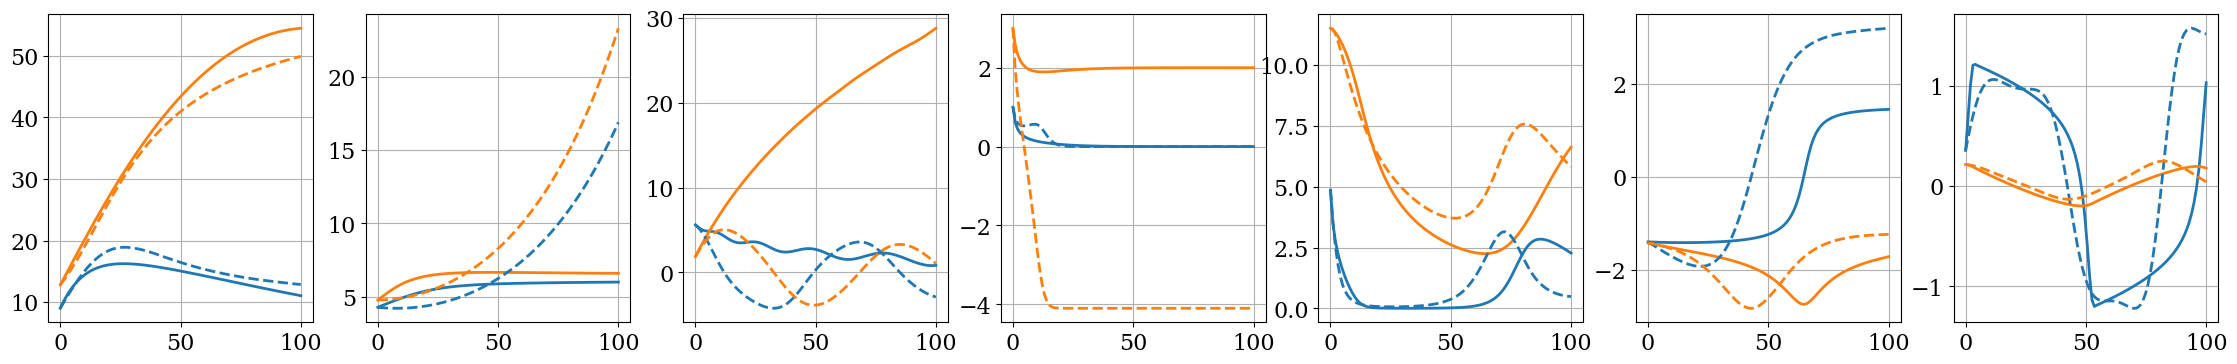

In [43]:
n = len(strogatz_names)
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
dstr.rescale = True
dstr.beam_size = 3

times = np.linspace(0, 100, 100)
for i ,name in enumerate(strogatz_names[::]):
    data = fetch_data(name)
    print(i, end=' ')
    x = data['x'].values.reshape(-1,1)[:100]
    y = data['y'].values.reshape(-1,1)[:100]
    trajectory = np.concatenate((x,y), axis=1)
    #tree = plot_predictions(times, trajectory, dstr, verbose=False)
    #print(env.simplifier.readable_tree(tree))

    for dim in range(len(trajectory[0])):
        axarr[i].plot(times, trajectory[:,dim], color=f'C{dim}', label='True')
    candidates = dstr.fit(times, trajectory)
    for tree in candidates[0][:1]:
        print(env.simplifier.readable_tree(tree))
        pred_trajectory = integrate_ode(trajectory[0], times, tree, "solve_ivp", debug=False)
        try:
            for dim in range(len(trajectory[0])):
                axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
        except: 
            print(traceback.format_exc())
plt.show()


In [55]:
datasets = {}
for file in glob.glob("invar_datasets/*"):
    with open(file) as f:
        lines = (line for line in f if not line.startswith('%') and not line.startswith('x'))
        data = np.loadtxt(lines)
        data = data[data[:,0]==0]
    datasets[file.split('/')[-1]] = data
n = len(datasets)

In [60]:
fig, axarr = plt.subplots(1,n,figsize=(n*4,4))
dstr.rescale = True
dstr.model.beam_type = 'sampling'
dstr.model.beam_size = 3
dstr.model.beam_temperature = .01

for i, (name, data) in enumerate(datasets.items()):
    #if i==5: break
    print(i, end=' ')
    times = data[:,1]
    x     = data[:,2]
    y     = data[:,3]
    trajectory = np.concatenate([x[:,None], y[:,None]], axis=1)
    idx = np.random.permutation(len(times))
    shuffled_times, x, y = times[idx], x[idx], y[idx]
    shuffled_trajectory = np.concatenate([x[:,None], y[:,None]], axis=1)

    for dim in range(len(trajectory[0])):
        axarr[i].plot(times, trajectory[:,dim], color=f'C{dim}', label='True')
    candidates = dstr.fit(shuffled_times, shuffled_trajectory)
    for tree in candidates[0][:1]:
        print(env.simplifier.readable_tree(tree))
        pred_trajectory = integrate_ode(trajectory[0], times, tree, "solve_ivp", debug=False)
        try:
            for dim in range(len(trajectory[0])):
                axarr[i].plot(times, pred_trajectory[:,dim], color=f'C{dim}', ls='--', label='Pred')
        except: 
            print('Fail', end=' ')
plt.show()

0 -1.0004*x_1  ,  -0.0578*x_0*(-1.0983*x_0 + 0.1119*x_1) + 0.9096*x_0
1 

# Play with generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
add,mul,-0.4596,x_0,mul,-6.6265,mul,x_1,x_2,|,add,mul,-0.1459,x_2,mul,-1.4852,x_0,|,add,mul,-3.4795,x_2,mul,0.1394,mul,x_2,add,mul,8.1739,x_0,add,mul,-0.1495,x_2,mul,-0.7078,mul,x_1,x_2


-0.4596*x_0 - 6.6265*x_1*x_2

-1.4852*x_0 - 0.1459*x_2

0.1394*x_2*(8.1739*x_0 - 0.7078*x_1*x_2 - 0.1495*x_2) - 3.4795*x_2

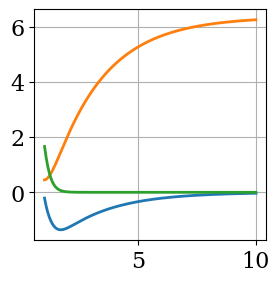

mul,x_1,add,mul,2.4534,x_1,mul,-16.9224,x_2,|,add,mul,0.1231,x_0,add,mul,-7.6672,x_2,mul,-0.0617,mul,x_0,x_2,|,mul,0.0877,mul,x_0,x_1


x_1*(2.4534*x_1 - 16.9224*x_2)

-0.0617*x_0*x_2 + 0.1231*x_0 - 7.6672*x_2

0.0877*x_0*x_1

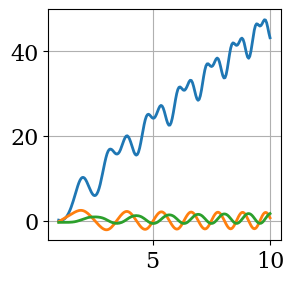

mul,-0.7577,mul,x_0,pow,x_2,2,|,add,mul,-0.0565,x_0,add,mul,-2.4299,pow,x_0,2,mul,-5.2982,x_2,|,mul,x_2,add,mul,-0.8656,x_2,add,mul,-3.9361,x_0,mul,-0.0933,mul,x_0,add,mul,0.1351,x_2,mul,-0.3827,x_1


-0.7577*x_0*x_2**2

-2.4299*x_0**2 - 0.0565*x_0 - 5.2982*x_2

x_2*(-0.0933*x_0*(-0.3827*x_1 + 0.1351*x_2) - 3.9361*x_0 - 0.8656*x_2)

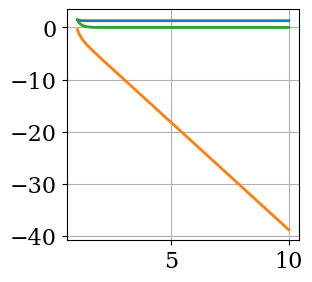

mul,x_0,add,mul,12.3676,x_2,add,mul,-0.2383,x_1,add,mul,-4.0475,x_0,mul,-0.4861,mul,x_0,x_2,|,add,mul,2.0240,x_2,mul,3.4314,mul,x_1,x_2,|,add,mul,0.0949,x_2,add,mul,4.2678,x_1,add,mul,11.3019,x_0,mul,0.6530,mul,x_0,mul,x_1,x_2


x_0*(-0.4861*x_0*x_2 - 4.0475*x_0 - 0.2383*x_1 + 12.3676*x_2)

3.4314*x_1*x_2 + 2.024*x_2

0.653*x_0*x_1*x_2 + 11.3019*x_0 + 4.2678*x_1 + 0.0949*x_2

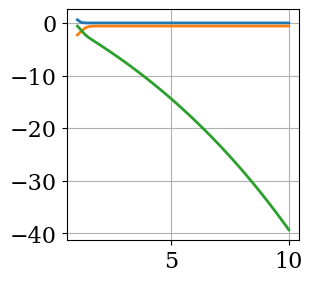

add,mul,-5.5069,x_0,add,mul,-3.7747,x_1,add,mul,-13.9106,x_2,mul,-0.1161,mul,x_0,x_2,|,add,mul,-0.6277,x_2,add,mul,-1.3709,x_0,mul,-0.3247,mul,x_0,x_2,|,add,mul,-0.7340,x_2,mul,-0.4421,mul,x_0,add,mul,-0.0551,x_2,mul,-0.0703,x_1


-0.1161*x_0*x_2 - 5.5069*x_0 - 3.7747*x_1 - 13.9106*x_2

-0.3247*x_0*x_2 - 1.3709*x_0 - 0.6277*x_2

-0.4421*x_0*(-0.0703*x_1 - 0.0551*x_2) - 0.734*x_2

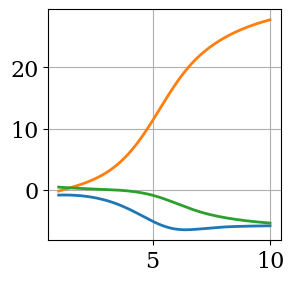

add,mul,3.8115,x_1,mul,-0.4508,pow,x_2,2,|,add,mul,0.0751,x_2,mul,-4.9149,x_0,|,add,mul,1.6847,x_1,mul,-4.1769,x_2


3.8115*x_1 - 0.4508*x_2**2

-4.9149*x_0 + 0.0751*x_2

1.6847*x_1 - 4.1769*x_2

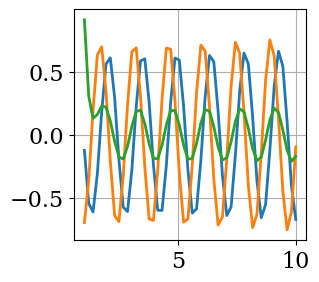

add,mul,-0.1138,x_2,add,mul,-11.1468,x_1,mul,1.0856,mul,x_1,pow,x_0,2,|,add,mul,0.5905,x_2,add,mul,4.8097,x_0,mul,10.0099,mul,x_0,x_1,|,mul,x_2,add,mul,-1.3862,x_2,add,mul,-11.7959,x_1,mul,-0.0619,mul,x_1,x_2


1.0856*x_0**2*x_1 - 11.1468*x_1 - 0.1138*x_2

10.0099*x_0*x_1 + 4.8097*x_0 + 0.5905*x_2

x_2*(-0.0619*x_1*x_2 - 11.7959*x_1 - 1.3862*x_2)

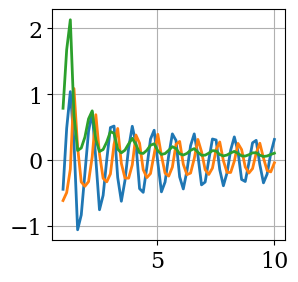

mul,1.1171,mul,x_1,x_2,|,add,mul,0.2836,x_0,add,mul,-0.1525,x_1,mul,-1.7024,x_2,|,add,mul,11.2900,x_0,add,mul,-1.0088,x_1,mul,-1.6421,x_2


1.1171*x_1*x_2

0.2836*x_0 - 0.1525*x_1 - 1.7024*x_2

11.29*x_0 - 1.0088*x_1 - 1.6421*x_2

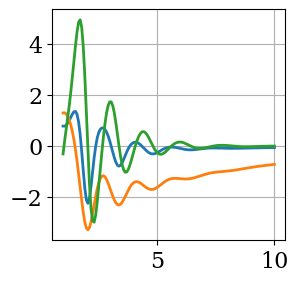

add,mul,-0.4337,x_2,add,mul,-14.6578,x_0,mul,-4.3744,mul,x_1,x_2,|,add,mul,0.1212,x_2,mul,-14.7474,x_1,|,add,mul,0.2256,x_2,mul,-1.0227,x_1


-14.6578*x_0 - 4.3744*x_1*x_2 - 0.4337*x_2

-14.7474*x_1 + 0.1212*x_2

-1.0227*x_1 + 0.2256*x_2

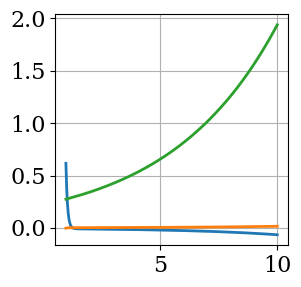

mul,x_0,add,mul,0.6523,x_1,mul,0.1439,x_2,|,mul,add,mul,0.0548,x_2,mul,12.1626,x_0,add,mul,10.4472,x_0,mul,-16.8290,x_2,|,add,mul,0.3562,x_2,mul,3.9851,x_1


x_0*(0.6523*x_1 + 0.1439*x_2)

(10.4472*x_0 - 16.829*x_2)*(12.1626*x_0 + 0.0548*x_2)

3.9851*x_1 + 0.3562*x_2

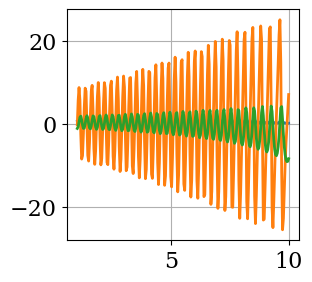

36.8
0.2777777777777778


In [56]:
from notebook_utils import *
%load_ext autoreload
%autoreload 2

parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.debug = False
args.min_dimension = 3
args.max_dimension = 3
#args.sign_as_token = True
#args.prob_t = 0
#args.max_dimension = 4
#args.max_unary_ops = 4
#args.max_unary_depth = 4
#args.prob_prefactor = 1
#args.use_controller = True
#args.expand=False
#args.max_trajectory_value = 1e2
#args.max_unary_depth = 5
#args.expand = False
#args.prob_prefactor = 1
#args.time_range = 10
args.subsample_ratio = 0
args.operators_to_use = "add:3,mul:1"
args.float_descriptor_length = 2
#args.discard_stationary_trajectory_prob = 1
    
env = FunctionEnvironment(args)

env.rng = np.random.RandomState()
i=0
lens = []
trees = []
for itotal in range(1000):
    try: samples, error = env._gen_expr(train=True)
    except MyTimeoutError: continue
    if i==10: break
    if not error:
        tree = samples["tree"]
        lens.append(len(tree.prefix().split(',')))
        tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
        for expr in tree_sympy:
            display(expr)
        plt.figure(figsize=(3,3))
        for dim in range(samples["infos"]["dimension"]): 
            #print(samples["trajectory"][-10:])
            plt.plot(samples["times"], samples["trajectory"][:, dim])
        plt.show()
        trees.append(tree)
        i+=1
print(np.mean(lens))
print((i/(itotal)))


In [9]:
math.frexp(100)

(0.78125, 7)

In [159]:
rng = np.random.RandomState(18)
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=rng, dimension=2, nb_unary_ops=1)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = rng.randn(dimension)
t = np.linspace(1,2,100)

#trajectory = integrate_ode(y0, t, tree, ode_integrator='odeint', debug=True)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

for dim in range(dimension):
    plt.plot(t,trajectory[:,dim])


System :


42.3801*x_0*(1 - 0.0819*x_0)**2*(0.82*x_0 + 0.82*x_1) - 0.606

-4.21*x_0 + 0.332*x_1*(9.39*x_1 + 0.0744*(0.9213*x_0 + 1)**2) - 4.21*x_1 - 0.544

AttributeError: module 'symbolicregression.envs' has no attribute 'Simplifier'

In [57]:
trajectory[0]

Array([-0.20161551,  0.4996451 ], dtype=float32, weak_type=True)

In [26]:
tree_sympy

[16.58*x_0*x_1**2*cos(4.85*x_0 + 0.55) - 0.5,
 x_1*(-0.119*x_0*x_1 - 5.7*x_0 - 0.119/(1.86*x_0 + 0.55)) + 0.314]

In [28]:
from symbolicregression.envs.export_jax import *
dimension=2
tree = tree_sympy[0]
symbols = list(tree.free_symbols)
jax_trees, jax_params = [], []
for tree in tree_sympy:
    jax_tree, jax_param = sympy2jax(tree, symbols)
    jax_trees.append(jax_tree)
    jax_params.append(jax_param)
def func(x):
    print(jax_trees[0](x, jax_params[0]).shape)
    return jax.numpy.concatenate([jax_tree(x, jax_param).reshape(-1,1) for jax_tree, jax_param in zip(jax_trees, jax_params)], axis=1)

In [29]:
import jax.random as random
key = random.PRNGKey(0)
X = random.normal(key, (10, 2))
func(X).shape

(10,)


(10, 2)

In [77]:
def f(t, y):
    return tree_jax(*y)

y0 = np.random.randn(dimension)
t = np.linspace(1,2,100)
trajectory = integrate_ode(y0, t, tree, ode_integrator='jax', debug=True)

AttributeError: 'Add' object has no attribute 'infix'

In [ ]:
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = (0,1)
def func(t,y):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        #sol = odeint(func, y0, t)
        sol = solve_ivp(func, t, y0)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

t = sol.t
sol = sol.y.T
for dim in range(dimension):
    plt.plot(t,sol[:,dim])


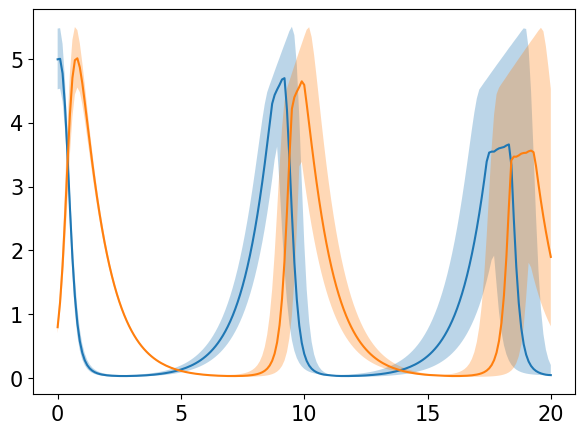

In [6]:
from numbalsoda import lsoda_sig, lsoda
from matplotlib import pyplot as plt
import numpy as np
import numba as nb

@nb.cfunc(lsoda_sig)
def f(t, u, du, p):
    du[0] = u[0]-u[0]*u[1]
    du[1] = u[0]*u[1]-u[1]

funcptr = f.address
t_eval = np.linspace(0.0,20.0,201)
np.random.seed(0)

def main(n):
    u1 = np.empty((n,len(t_eval)), np.float64)
    u2 = np.empty((n,len(t_eval)), np.float64)
    for i in nb.prange(n):
        u0 = np.empty((2,), np.float64)
        u0[0] = np.random.uniform(4.5,5.5)
        u0[1] = np.random.uniform(0.7,0.9)
        usol, success = lsoda(funcptr, u0, t_eval, rtol = 1e-8, atol = 1e-8)
        u1[i] = usol[:,0]
        u2[i] = usol[:,1]
    return u1, u2

u1, u2 = main(10000)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[7,5])
low, med, high = np.quantile(u1,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
low, med, high = np.quantile(u2,(.025,.5,.975),axis=0)
ax.plot(t_eval,med)
ax.fill_between(t_eval,low,high,alpha=0.3)
plt.show()

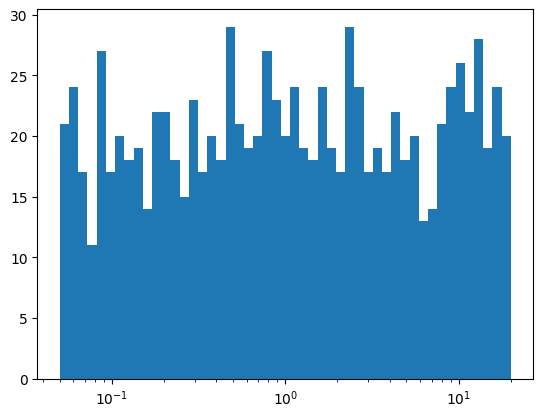

In [11]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.max_exponent_prefactor = 1
args.debug=False
args.ode_integrator = 'solve_ivp'
    
env = FunctionEnvironment(args)

rng = np.random.RandomState(0)
nums = []
for _ in range(1000):
    nums.append(abs(float(env.generator.generate_float(rng))))
# make a logartihmic histogram
nums = np.array(nums)
nums = nums[nums>0]
bins = np.logspace(np.log10(min(nums)),np.log10(max(nums)), 50)
plt.hist(nums, bins=bins)
plt.xscale('log')